In [36]:
%pylab inline
import numpy as np
import torch
import os
import pandas as pd
import time
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from nilearn import plotting

from ADNI_dataset import *
from BRATS_dataset import *
from ATLAS_dataset import *
from Model_alphaWGAN import *
from utils import *

import pytorch_ssim
from ipdb import set_trace

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [43]:
# used to store the MMD ans MS-SSIM
try:
    os.mkdir('./test_data')
except FileExistsError:
    pass
workers = 4
BATCH_SIZE = 6
latent_dim = 1000

Use_BRATS = False
Use_ATLAS = False
gpu = 0

In [44]:
trainset = ADNIdataset(augmentation=True)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
#'flair' or 't2' or 't1ce'
# trainset = BRATSdataset(imgtype='flair')
# train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
#                                                num_workers=workers)

# trainset = ATLASdataset(augmentation=True)
# train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)

gen_load = inf_train_gen(train_loader)

## Pre-trained Generator Load

In [45]:
#-------------------------------------------
#Choose the Model you want!
from Model_alphaWGAN import *
# from Model_alphaWGAN import Discriminator
# from Model_alphaGAN import Generator
# from Model_VAEGAN import Generator
# from Model_VAEGAN import Encoder
# from Model_WGAN import Generator
#-------------------------------------------

G = Generator(noise=latent_dim).cuda(gpu)
# E = Encoder(out_class = latent_dim, gpu_ind=gpu).cuda(gpu)
E = Discriminator(out_class = latent_dim, is_dis=False).cuda(gpu)
#-----------------------
#Load Pre-trained model
#-----------------------

#------------Trained Model of ADNI dataset---------------------
# G.load_state_dict(torch.load('./wl_checkpoint_2/G_iter67500.pth')) # Alpha-WGAN-GP
# E.load_state_dict(torch.load('./trained/E_iter12500.pth')) # Alpha-WGAN-GP Encoder
# G.load_state_dict(torch.load('./wl_checkpoint_noBN/G_iter75500.pth')) #VAE-GAN
# G.load_state_dict(torch.load('./vae_checkpoint/G_VG_ep_299.pth')) #VAE-GAN
# G.load_state_dict(torch.load('./checkpoint/G_W_iter3000.pth')) #WGAN-GP

#------------Trained Model of ATLAS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_at_G.pth'))

#------------Trained Models of BRATS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_fl_G.pth'))
# G.load_state_dict(torch.load('./checkpoint/Ours_t2_G.pth'))

Fake Image - slice series visualization

You can change the axis (x , y , z ) by changing  display_mode = 'x' / 'y' / 'z'

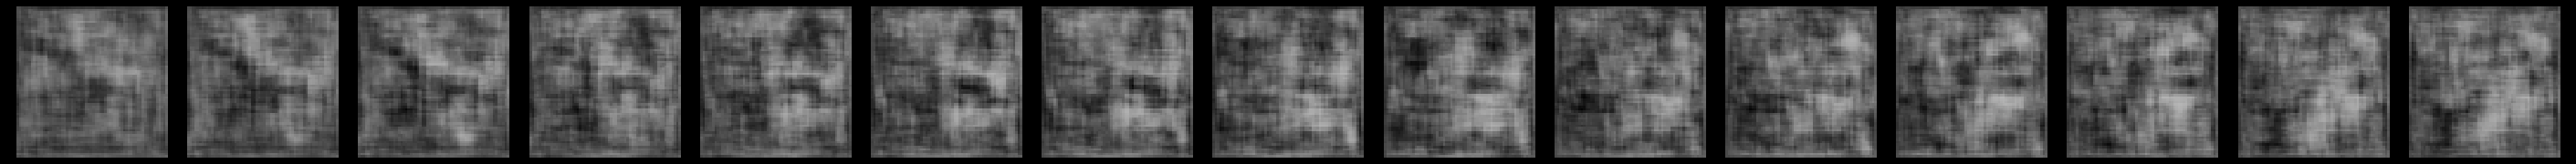

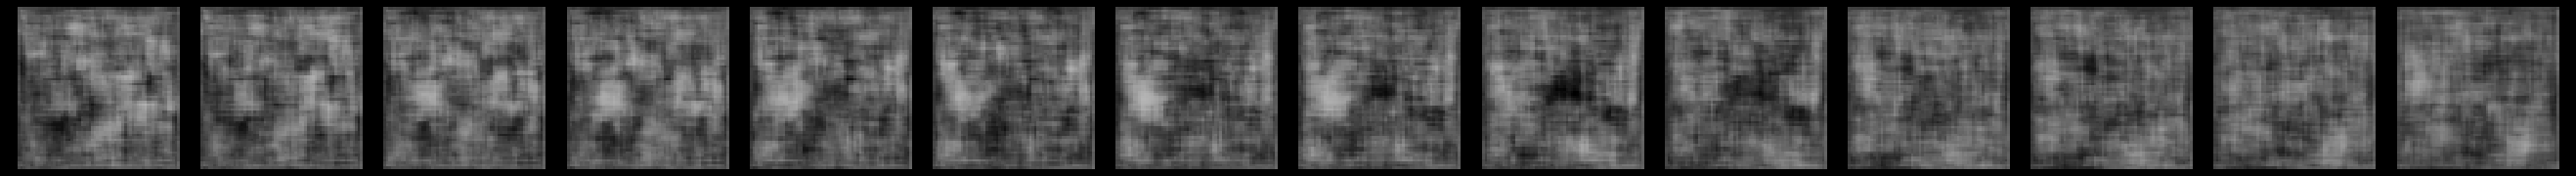

In [40]:
Show_color = False

noise = torch.randn(1, latent_dim).cuda(gpu)
fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))

arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]
if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

Fake Image - Center cut slices Visualization

In [ ]:
noise = Variable(torch.randn((1, 1000)).cuda(gpu))
# fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
plotting.plot_img(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.plot_anat(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.show()

Real Image - Slice series visualization

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)

Show_color = False

image = gen_load.__next__()
featmask = np.squeeze(image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]

if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

# FID test on train-test split

In [ ]:
real_data = np.ones((100, 2))
real_data[:50, 0] = 2
gen_data = np.ones((100, 2)) * 9
gen_data[50:, 0] = 2
calculate_fid(real_data, gen_data, cuda_ind=gpu)

In [ ]:
train_set, test_set = torch.utils.data.random_split(trainset, [int(len(trainset)/2), len(trainset)-int(len(trainset)/2)])
train_loader, test_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=workers),torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True, num_workers=workers)
train_loader, test_loader = inf_train_gen(train_loader), inf_train_gen(test_loader)
total = 0 
for i in range(10):
    start = time()
    x, y = train_loader.__next__(), test_loader.__next__()
    x, y = x.reshape(64, -1), y.reshape(64, -1)
    score = calculate_fid(np.array(x), np.array(y))
    total += score
    print(score, f'time spent {time()-start}')
print('total', total/10)


# FID test on model

In [ ]:
path = 'vae_checkpoint'
total = 0
# G.load_state_dict(torch.load(f'./{path}/G_iter200000.pth'))
# E.load_state_dict(torch.load(f'./{path}/E_iter200000.pth'))
G.load_state_dict(torch.load(f'./{path}/G_VG_ep_100.pth'))
E.load_state_dict(torch.load(f'./{path}/E_VG_ep_100.pth'))
for i in range(10):
    start = time()
    images = gen_load.__next__().cuda(gpu)
    image = images[0]
#     z_r = Variable(torch.randn((1, 1000)).cuda(gpu), requires_grad=True)
    if 'vae' in path:
        z_r = E(images)[2][0]
    else:
        z_r = E(images)[0]
    x_r = G(z_r)
#     image, x_r = image.reshape(64, -1), x_r.reshape(64, -1)
    image, x_r = image[0, 32], x_r[0, 0, 32]
    score = calculate_fid(image.cpu().detach(), x_r.cpu().detach())
    total += score
    print(score, f'time spent {time()-start}')
print('total', total/10)
plt.imshow(np.array(image.cpu()))
plt.show()
plt.imshow(np.array(x_r.detach().cpu()))
plt.show()


In [ ]:
%debug

# MS-SSIM Curve

In [ ]:
ssim_pth = 'alpha_checkpoint_2'
G.load_state_dict(torch.load(f'./{ssim_pth}/G_iter1000.pth'))
calc_ssim(G, 1000, ssim_pth, no_write=False, gpu=gpu)
# for i in range(1, 301, 2):
for i in range(5000, 200001, 5000):
#     G.load_state_dict(torch.load(f'./{ssim_pth}/G_VG_ep_{i}.pth'))
    G.load_state_dict(torch.load(f'./{ssim_pth}/G_iter{i}.pth'))
    calc_ssim(G, i, ssim_pth, no_write=False, gpu=gpu)

# MS-SSIM for real images

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
test_loader = inf_train_gen(train_loader)

i = 0
sum_ssim = 0
while i < 494:
    img1, img2 = test_loader.__next__()
    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    i += 1
    if i % 100 == 0:
        print(i, sum_ssim/ (494 * 2))
        
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
test_loader = inf_train_gen(train_loader)
while i < 494 * 2:
    img1, img2 = test_loader.__next__()
    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    i += 1
    if i % 100 == 0:
        print(i, sum_ssim/ (494 * 2))
print(sum_ssim/(494 * 2))

# Maximum-Mean Discrepancy Score

### calculate averaged mmd score

In [ ]:
mmd_pth = 'wl_checkpoint_mse'
G.load_state_dict(torch.load(f'./{mmd_pth}/G_iter200000.pth'))
calc_mmd(train_loader, G, 0, count=100, gpu_ind=gpu, path=mmd_pth, no_write=False)

### create mmd cruve

In [ ]:
mode ='multiscale'
mmd_pth = 'wl_checkpoint_mse/'
last_ind = int(read_mmd(mmd_pth, name=f'{mode}_mmd.csv'))
end = 100001
if not last_ind:
    inds = [1000] + list(range(5000, end, 5000))
elif last_ind == 1000:
    inds = range(5000, end, 5000)
else: 
    inds = range(last_ind + 5000, end, 5000)
for i in inds:
    i = int(i / 1000) if 'vae' in mmd_pth else i
    G.load_state_dict(torch.load(f'./{mmd_pth}/G_iter{i}.pth'))
#     G.load_state_dict(torch.load(f'./{mmd_pth}/G_VG_ep_{i}.pth'))
    calc_mmd(train_loader, G, i, count=10, gpu_ind=gpu, mode=mode, path=mmd_pth, no_write=False)


iteration: 1000, count: 0, Mean: 0.057345423847436905, cost 49.755637884140015 seconds

iteration: 1000, count: 1, Mean: 0.05771571397781372, cost 49.20128512382507 seconds

iteration: 1000, count: 2, Mean: 0.0583774596452713, cost 48.74072313308716 seconds

iteration: 1000, count: 3, Mean: 0.057196781039237976, cost 49.05217528343201 seconds

iteration: 1000, count: 4, Mean: 0.05738779902458191, cost 49.78555178642273 seconds

iteration: 1000, count: 5, Mean: 0.057124823331832886, cost 54.19050168991089 seconds

iteration: 1000, count: 6, Mean: 0.05793679878115654, cost 55.40603303909302 seconds

iteration: 1000, count: 7, Mean: 0.056546084582805634, cost 54.54304099082947 seconds

iteration: 1000, count: 8, Mean: 0.05739389732480049, cost 54.705580949783325 seconds

iteration: 1000, count: 9, Mean: 0.05670958757400513, cost 54.46154570579529 seconds
Total_mean:0.057373436912894246 STD:0.0005159675662953603

iteration: 5000, count: 0, Mean: 0.08190398663282394, cost 54.72263240814209

%debug

### visualize mmd curve

In [ ]:
df = load_csv('./trained/wl_gan_mmd.csv')
plt.figure()
df['mmd_score'].plot()

### alpha gan Images PCA Visualization

index: 100000, sample_mean (blue): -0.8607295155525208 sample_var: 0.05881352722644806, real_mean (yellow): -0.8602398633956909 real_var: 0.05524706467986107


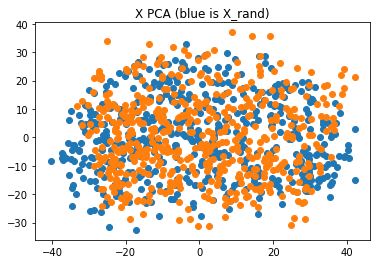

index: 95000, sample_mean (blue): -0.8588852882385254 sample_var: 0.05874720215797424, real_mean (yellow): -0.8587917685508728 real_var: 0.05643409118056297


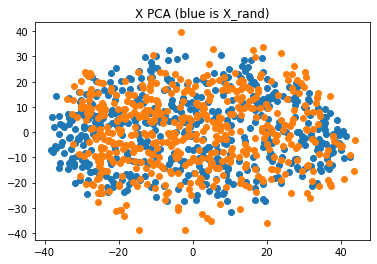

index: 90000, sample_mean (blue): -0.8590981364250183 sample_var: 0.060025475919246674, real_mean (yellow): -0.8576990962028503 real_var: 0.057180412113666534


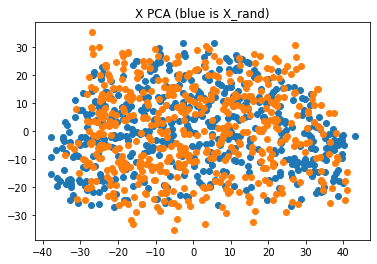

index: 85000, sample_mean (blue): -0.849587082862854 sample_var: 0.0653609037399292, real_mean (yellow): -0.8604873418807983 real_var: 0.05516573041677475


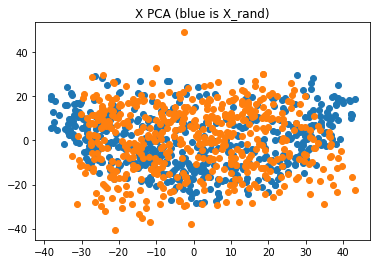

index: 80000, sample_mean (blue): -0.8724542856216431 sample_var: 0.04594936966896057, real_mean (yellow): -0.8582874536514282 real_var: 0.05681659281253815


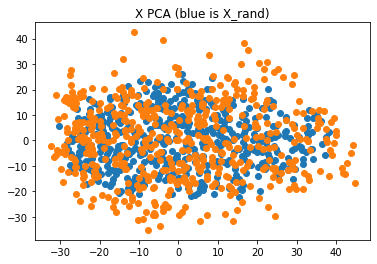

index: 75000, sample_mean (blue): -0.8511186838150024 sample_var: 0.061963945627212524, real_mean (yellow): -0.8585846424102783 real_var: 0.05642073601484299


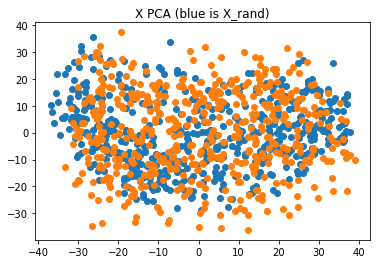

index: 70000, sample_mean (blue): -0.8561223149299622 sample_var: 0.06082054600119591, real_mean (yellow): -0.8590866327285767 real_var: 0.05609583854675293


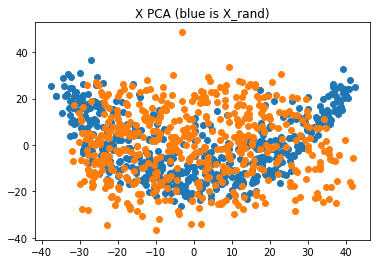

index: 65000, sample_mean (blue): -0.8640629053115845 sample_var: 0.053088922053575516, real_mean (yellow): -0.8607543110847473 real_var: 0.05476025491952896


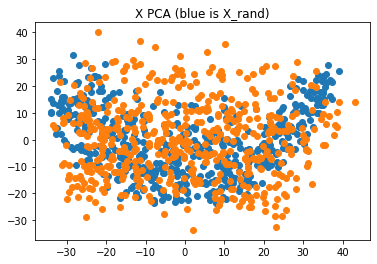

index: 60000, sample_mean (blue): -0.8525511026382446 sample_var: 0.06256710737943649, real_mean (yellow): -0.8583078384399414 real_var: 0.056784581393003464


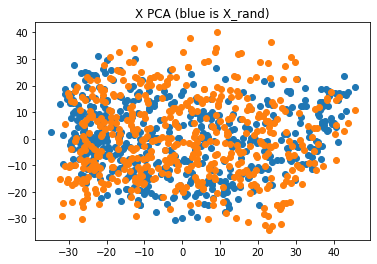

index: 55000, sample_mean (blue): -0.8588482141494751 sample_var: 0.05713260918855667, real_mean (yellow): -0.8588211536407471 real_var: 0.05635853484272957


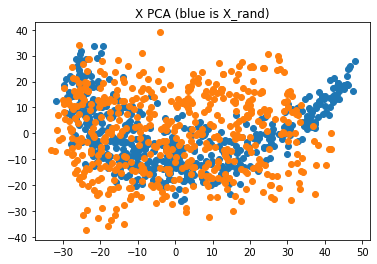

index: 50000, sample_mean (blue): -0.8579802513122559 sample_var: 0.05724087357521057, real_mean (yellow): -0.8582116365432739 real_var: 0.056913409382104874


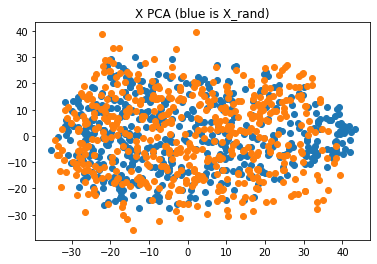

index: 45000, sample_mean (blue): -0.8666169047355652 sample_var: 0.04989303648471832, real_mean (yellow): -0.8589050769805908 real_var: 0.05630044266581535


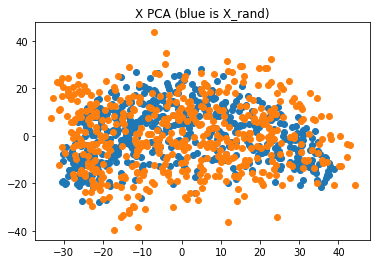

index: 40000, sample_mean (blue): -0.869987964630127 sample_var: 0.04969348758459091, real_mean (yellow): -0.8583616018295288 real_var: 0.05673681199550629


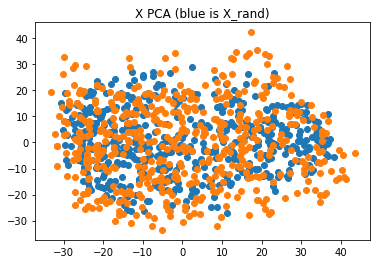

index: 35000, sample_mean (blue): -0.863767683506012 sample_var: 0.05355844646692276, real_mean (yellow): -0.8590511679649353 real_var: 0.056302521377801895


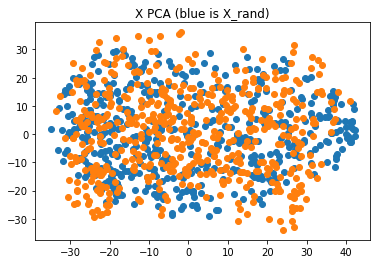

index: 30000, sample_mean (blue): -0.8603581786155701 sample_var: 0.05664420127868652, real_mean (yellow): -0.8590481281280518 real_var: 0.05617523193359375


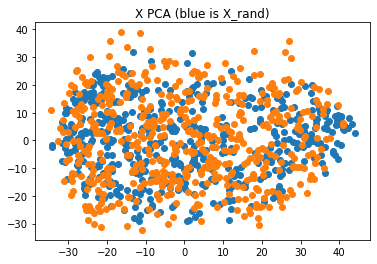

index: 25000, sample_mean (blue): -0.8758816719055176 sample_var: 0.04374849051237106, real_mean (yellow): -0.8586881756782532 real_var: 0.056627050042152405


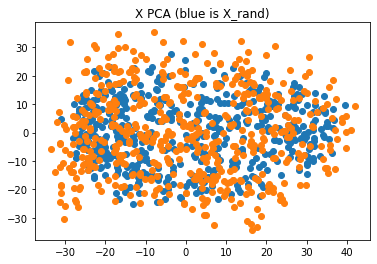

index: 20000, sample_mean (blue): -0.8663140535354614 sample_var: 0.05376215651631355, real_mean (yellow): -0.8590232133865356 real_var: 0.05612944811582565


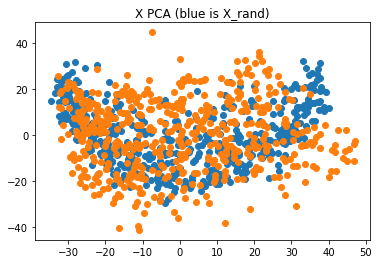

index: 15000, sample_mean (blue): -0.8630473613739014 sample_var: 0.04970715194940567, real_mean (yellow): -0.8591362833976746 real_var: 0.05618927627801895


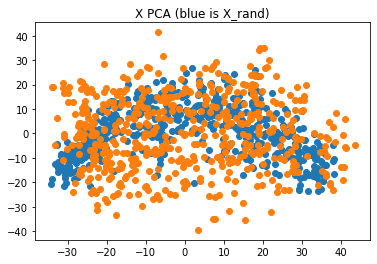

index: 10000, sample_mean (blue): -0.8446236848831177 sample_var: 0.06141456589102745, real_mean (yellow): -0.8584929704666138 real_var: 0.05664540454745293


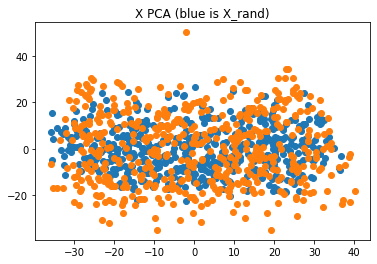

index: 5000, sample_mean (blue): -0.8487229347229004 sample_var: 0.05896150320768356, real_mean (yellow): -0.8583561182022095 real_var: 0.0567067414522171


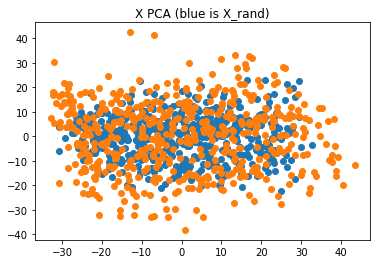

In [25]:
for i in range(100000, 0, -5000):
# for i in range(122, -1, -10):
    G.load_state_dict(torch.load(f'./alpha_checkpoint/G_iter{i}.pth'))
#     G.load_state_dict(torch.load(f'./vae_checkpoint_gp/G_iter{i}.pth'))
    viz_pca(G, trainset, latent_size=latent_dim, index=i, gpu_ind=gpu)

### vaegan Images PCA Visualization

In [ ]:
for i in range(122, -1, -10):
    G.load_state_dict(torch.load(f'./vae_checkpoint/E_VG_ep_{i}.pth'))
    viz_pca(G, trainset, latent_size=latent_dim, index=i, gpu_ind=gpu)

In [ ]:
def show_pca_cluster(x, PC_list, interval=3):
    for i in range(x, x+interval):
        sample_ind = PC_list[i][2]
        feat = sample_df.iloc[int(sample_ind)].to_numpy().reshape((64, 64, 64))
        featmask = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(featmask, title=f'x_val: {round(PC_list[i][0], 2)} y_val: {round(PC_list[i][1], 2)} sample_index: {int(sample_ind)}')
        plotting.show()

# concatenate the sample index 
PC_list = list(np.concatenate((PCs, np.array([i for i in range(512)]).reshape(512, 1)), 1))
# sort by x or y of PCAs
PC_list.sort(key=lambda x: x[1])

# for i in range(0, 512, 60):
#     show_pca_cluster(i, PC_list, 1)

show_pca_cluster(0, PC_list, 10)



### visualize all training images

In [ ]:
viz_all_imgs('../../ADNI', [0])

### loss check

In [ ]:
loss_df = load_loss(path='./wl_checkpoint_2/loss.csv')
# print(loss_df)
# alpha_wgan
loss_df[['d_fake', 'd_real_loss', 'd_recon', 'err_enc']].plot() 
# vae_gan
# loss_df[['d_real_loss', 'd_fake', 'd_recon', 'err_enc']].plot() 

# plt.figure()
# # loss_df[['loss1', 'mmd_loss']].plot()
# plt.figure()
# loss_df[['gp_r', 'gp_h', 'l1_loss']].plot()
plt.figure(figsize=(400, 400))
loss_df.plot()

### latent vector pca

In [ ]:
E.load_state_dict(torch.load(f'./checkpoint/E_iter33500.pth'))
viz_pca(E, trainset, latent_size=latent_dim, index=i, is_cd=True)

In [ ]:
# for VAEGAN
for i in range(100, -1, -10):
    E.load_state_dict(torch.load(f'./vae_checkpoint_1/E_VG_ep_{i}.pth'))
    viz_pca(E, trainset, latent_size=latent_dim, index=i, is_cd=True, gpu_ind=gpu, batch_size=1)

In [ ]:
# for AlphaWGAN
for i in range(42000, 0, -2000):
    E.load_state_dict(torch.load(f'./wl_checkpoint/E_iter{i}.pth'))
    viz_pca(E, trainset, latent_size=latent_dim, index=i, is_cd=True, gpu_ind=gpu)

### delete CD and D

# Calculate the paddings of fake images

In [ ]:
G = Generator(noise=1000).cuda(gpu)
G.load_state_dict(torch.load('./trained/G_iter12500.pth'))

def get_padding(feat, axis=0):
    feat = np.swapaxes(feat, 0, axis)
    output = [0, 0]
    for i in range(feat.shape[0]):
#         print(feat[i].sum())
        if feat[i].sum() > -4000:
            output[0] = i
            break
    for i in range(feat.shape[0] - 1, -1, -1):
        if feat[i].sum() > -4000:
            output[1] = feat.shape[0] - i - 1
            break
    return output
    
for i in range(512):
    noise = torch.rand((1, 1000)).cuda(gpu)
    img = G(noise)
    featmask = np.squeeze((0.5*img+0.5).detach().cpu().numpy())
    print(f'ind: {i} padding 0-axis: {get_padding(featmask, 0)}', end=' ')
    print(f'ind: {i} padding 1-axis: {get_padding(featmask, 1)}', end=' ')
    print(f'ind: {i} padding 2-axis: {get_padding(featmask, 2)}')
#     featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
#     plotting.plot_img(featmask, title=f'ind: {i}')
#     plotting.show()

### intensity range check

In [ ]:
trainset = ADNIdataset(augmentation=True, img_size=64, normalization=False)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
for featmask in inf_train_gen(train_loader):
#     noise = torch.rand((1, 1000)).cuda()
#     featmask= G(noise)
#     featmask = np.squeeze((0.5*featmask+0.5).detach().cpu().numpy())
    lo, hi = featmask.min(), featmask.max()
    print(f'lo: {lo} hi: {hi}')
#     featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
#     plotting.plot_img(featmask, title=f'ind: {i}')
#     plotting.show()
    

In [ ]:
%debug

In [ ]:
from utils import sinkhorn_pointcloud as sp
import numpy as np
import torch
from ipdb import set_trace
from torch import optim
from torch.autograd import Variable

gpu=1
a = Variable(torch.randn((1000, 4)).cuda(gpu), requires_grad=True)
b = Variable(torch.randn((1000, 4)).cuda(gpu) * 0.01, requires_grad=True) 
g_optimizer = optim.Adam([a, b], lr=0.0002)
print(a.shape, b.shape)
for i in range(1000):
    g_optimizer.zero_grad()
    w_dist = sp.sinkhorn_loss(a, b, 0.1, 1000, 100, gpu=gpu)
    w_dist.backward()
    g_optimizer.step()
    
    if i % 100 == 0:
        print(w_dist)

In [ ]:
a = torch.randn((1, 5), requires_grad=True)
c = a * 2
c.requires_grad = True;
b = c.sum()
b.backward()
print(a.grad)
print(c.grad)
print(b.grad)
